In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import pickle
import torch
from physio import respiration
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy.interpolate import interp1d, CubicSpline
from customLib.preprocess import *
from models.models import LSTM
from customLib.peak_detection import find_mean_avg_r_peak_indices, detect_nk

e:\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Own dataset

In [ ]:
%matplotlib qt

In [211]:
aidmed_ecg_sampling_rate = 250
aidmed_resp_sampling_rate = 50

path = "E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\ecg_with_resp"

ecg_path = os.path.join(path, "27_ecg.npy")
resp_path = os.path.join(path, "27_resp.npy")
# author_labels_path = os.path.join(path, "2_resp.peaks")

ecg = np.load(ecg_path)
resp = np.load(resp_path)
# with open(author_labels_path, "rb") as f:
#     author_labels = pickle.load(f)

ecg_first_timestep = ecg[0][1]
ecg_last_timestep = ecg[-1][1]

resp_first_timestep = resp[0][1]
resp_last_timestep = resp[-1][1]

print("First ecg time stamp: ", ecg_first_timestep)
print("First respiration time stamp: ", resp_first_timestep)

print("Last ecg time stamp: ", ecg_last_timestep)
print("Last respiration time stamp", resp_last_timestep)

First ecg time stamp:  1727975616119.0
First respiration time stamp:  1727975616119.0
Last ecg time stamp:  1727975855973.0
Last respiration time stamp 1727975855973.0


In [212]:
try:
    if ecg_first_timestep != resp_first_timestep:
        raise ValueError("start-mismatch")
    if ecg_last_timestep != resp_last_timestep:
        raise ValueError("end-mismatch")
except ValueError as e:
    if str(e) == "start-mismatch":
        print("Start mismatch detected.")
        if ecg_first_timestep < resp_first_timestep:
            mismatch_idx = int(np.where(ecg[:, 1] >= resp_first_timestep)[0][1])  # Using column 1 for time
            ecg = np.delete(ecg, np.s_[:mismatch_idx], axis=0)
        else:
            mismatch_idx = int(np.where(resp[:, 1] >= ecg_first_timestep)[0][1])  # Using column 1 for time
            resp = np.delete(resp, np.s_[:mismatch_idx], axis=0)
    elif str(e) == "end-mismatch":
        print("End mismatch detected.")
        if ecg_last_timestep < resp_last_timestep:
            mismatch_idx = int(np.where(resp[:, 1] >= ecg_last_timestep)[0][1])  # Using column 1 for time
            resp = np.delete(resp, np.s_[mismatch_idx:], axis=0)
        else:
            mismatch_idx = int(np.where(ecg[:, 1] >= resp_last_timestep)[0][1])  # Using column 1 for time
            ecg = np.delete(ecg, np.s_[mismatch_idx:], axis=0)
    else:
        raise Exception("An unknown data timestamp mismatch occurred.")
finally:
    # if len(resp.shape) > 1:
    #     resp = resp[:, 0]  # Ensure resp is 1D if it had multiple columns
    # if len(ecg.shape) > 1:
    #     ecg = ecg[:, 0]  # Ensure ecg is 1D if it had multiple columns
    print("ECG shape:", ecg.shape, " Time:", ecg.shape[0] / aidmed_ecg_sampling_rate)
    print("RESP shape:", resp.shape, " Time:", resp.shape[0] / aidmed_resp_sampling_rate)


ECG shape: (59954, 2)  Time: 239.816
RESP shape: (11991, 2)  Time: 239.82


C:\Users\patry\AppData\Local\Temp\ipykernel_18600\2133047644.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


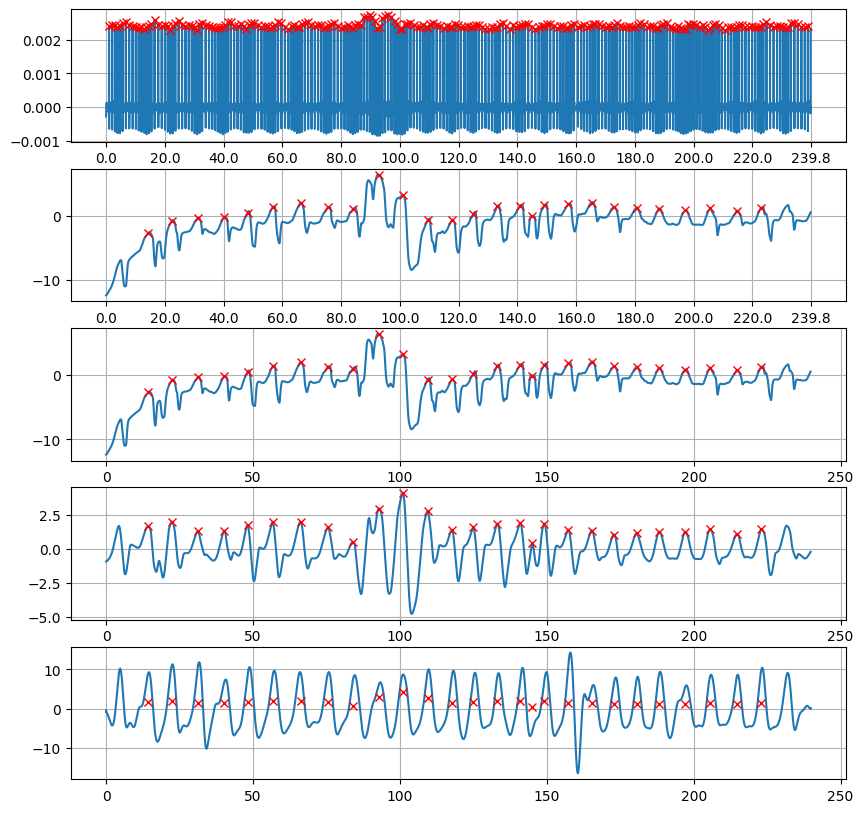

In [213]:
start_s = 0
stop_s = -1

ecg_recording_length = (stop_s - start_s) * aidmed_ecg_sampling_rate
resp_recording_length = (stop_s - start_s) * aidmed_resp_sampling_rate

start = start_s * aidmed_ecg_sampling_rate

if(stop_s == -1):
    stop = len(ecg)
else:
    stop = ecg_recording_length + start

ecg_slice = ecg[start:stop, :]
t_ecg = [x * 1/aidmed_ecg_sampling_rate for x in range(start, stop)]

start = start_s  * aidmed_resp_sampling_rate
if(stop_s == -1):
    stop = len(resp)
else:
    stop = resp_recording_length + start

resp_slice = resp[start:stop, :]
t_resp = [x * 1/aidmed_resp_sampling_rate for x in range(start, stop)]



# Cleaning RESP signal and plotting the local maximas
clean_resp = nk.rsp.rsp_clean(resp_slice[:,0], sampling_rate=50)
clean_resp = myConv1D(clean_resp, kernel_length=100, padding="same")
resp_peaks = nk.rsp_findpeaks(clean_resp, sampling_rate=50)['RSP_Peaks']

# EDR (ECG derived respiration)
r_peaks = detect_nk(ecg_slice[:,0], fs=aidmed_ecg_sampling_rate)
ecg_rate = nk.ecg_rate(r_peaks, sampling_rate=aidmed_ecg_sampling_rate, desired_length=len(ecg_slice[:,0]))
edr = nk.ecg_rsp(ecg_rate, sampling_rate=aidmed_ecg_sampling_rate)
edr = resample_signal(signal=edr, num_samples=len(resp_slice[:,0]))

# Own RESP labels
# author_labels_indices = np.where((author_labels >= start) & (author_labels < stop))
# author_labels = author_labels[author_labels_indices]
# author_labels -= start


# Plots
t_ticks_ecg = [x for x in t_ecg if x % 20 == 0] + [t_ecg[-1]]
t_ticks_resp = [x for x in t_resp if x % 20 == 0] + [t_resp[-1]]

fig, axs = plt.subplots(nrows=5)

ax = axs[0]
ax.plot(t_ecg, ecg_slice[:,0])
ax.plot(r_peaks * 1/aidmed_ecg_sampling_rate + start_s, ecg_slice[r_peaks, 0], 'rx')
ax.grid()
ax.set_xticks(t_ticks_ecg)

ax = axs[1]
ax.plot(t_resp, resp_slice[:,0])
ax.plot(resp_peaks * 1/aidmed_resp_sampling_rate + start_s, resp_slice[resp_peaks,0], 'rx')
ax.grid()
ax.set_xticks(t_ticks_resp)

ax = axs[2]
ax.plot(t_resp, resp_slice[:,0])
ax.plot(resp_peaks * 1/aidmed_resp_sampling_rate + start_s, resp_slice[resp_peaks,0], 'rx')
ax.grid()

ax = axs[3]
ax.plot(t_resp, clean_resp)
ax.plot(resp_peaks * 1/aidmed_resp_sampling_rate + start_s, clean_resp[resp_peaks], 'rx')
# ax.plot(author_labels * 1/aidmed_resp_sampling_rate + start_s, clean_resp[author_labels], 'gx')
ax.grid()

ax = axs[4]
ax.plot(t_resp, edr)
ax.plot(resp_peaks * 1/aidmed_resp_sampling_rate + start_s, clean_resp[resp_peaks], 'rx')
ax.grid()

fig.show()
fig.set_size_inches(10,10)

### Cutting periods of the signal with poor quality 

In [116]:
np.save(arr=ecg_slice, file=ecg_path)
np.save(arr=resp_slice, file=resp_path)
# with open(author_labels_path, "wb") as f:
#     pickle.dump(author_labels, file=f)

### Fixing labels manually, achieved via neurokit

In [195]:
resp_slice.shape

(11991, 2)

In [207]:
np.argmax(clean_resp[11000:])

472

In [208]:
resp_peaks = resp_peaks.tolist() + [252] + [11472]

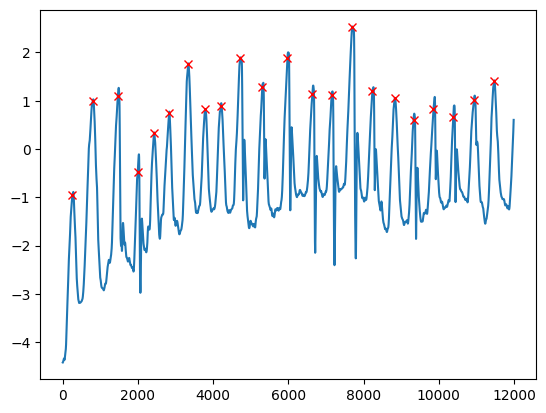

In [209]:
plt.plot([x for x in range(resp_slice.shape[0])], resp_slice[:,0])
plt.plot(resp_peaks, resp_slice[resp_peaks, 0], 'rx')

In [210]:
resp_peaks = np.unique(np.array(resp_peaks))
save_dir = "E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\ecg_with_resp\\"

with open(save_dir + "25_resp.peaks", "wb") as f:
    pickle.dump(resp_peaks, f)

### Poltting

In [50]:
# smoothening
resp_slice = myConv1D(signal=resp_slice[:,0], kernel_length=5, padding="same")
ecg_slice = myConv1D(signal=ecg_slice[:,0], kernel_length=5, padding="same")

# wavelet denoise
ecg_slice = dwt_denoise(signal=ecg_slice)

#normalization
# resp_slice = norm_min_max(resp_slice, -1, 1)
ecg_slice = norm_min_max(ecg_slice, -1, 1)

# neurokit for r_peaks detection
R_wave_indices = detect_nk(ecg_slice, fs=aidmed_ecg_sampling_rate)
R_wave = np.zeros_like(ecg_slice)
R_wave[R_wave_indices] = 1
R_wave_indices = np.where(R_wave == 1)[0]

# LSTM for r_peaks detection
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ecg_tensor = torch.Tensor(np.expand_dims(ecg_slice, 1)).to(device)
# model = LSTM(input_dim=1, hidden_size=32, loss_pos_weight=torch.Tensor([17]))
# model.load_state_dict(torch.load("./checkpoints/lstm/raw_ecgs/lstm_epoch_10_acc_99.88_f1_0.98.pt"))
# prediction =  model(ecg_tensor)
# prediction = prediction.detach().cpu().numpy()
# prediction = (prediction.flatten() > 0.6).astype(int)
# R_wave = find_mean_avg_r_peak_indices(prediction)
# R_wave_indices = np.where(R_wave == 1)[0]


R_wave_time = R_wave_indices * 1 / aidmed_ecg_sampling_rate

rr_intervals  = np.diff(R_wave_indices) * 1/aidmed_ecg_sampling_rate * 1000

rr_times = R_wave_time[:-1] - R_wave_time[0]

t_resampled = np.arange(0, rr_times[-1], 0.1)

rr_interpolator = CubicSpline(rr_times, rr_intervals)
rr_interpolated = rr_interpolator(t_resampled)

rr_interpolated = norm_min_max(rr_interpolated, -1 , 1)

rpa = ecg_slice[R_wave_indices]
rpa_t = R_wave_time - R_wave_time[0]

rpa_t_resampled = np.arange(0, rpa_t[-1], 0.1)

rpa_interpolator = CubicSpline(rpa_t, rpa)
rpa_interpolated = rpa_interpolator(rpa_t_resampled)

rpa_interpolated = norm_min_max(rpa_interpolated, -1 , 1)

ecg_rate = nk.ecg_rate(peaks=R_wave_indices, sampling_rate=250, desired_length=len(ecg_slice))
edr = nk.ecg_rsp(ecg_rate=ecg_rate, sampling_rate=250)

clean_resp = nk.rsp.rsp_clean(resp_slice, sampling_rate=50)
resp_peaks = nk.rsp_findpeaks(clean_resp, sampling_rate=50)['RSP_Peaks']

resp_df = respiration.compute_respiration(clean_resp, 250)
inspi_indices = resp_df[1]['inspi_index']

edr_resampled = resample_signal(edr, num_samples=len(resp_slice))

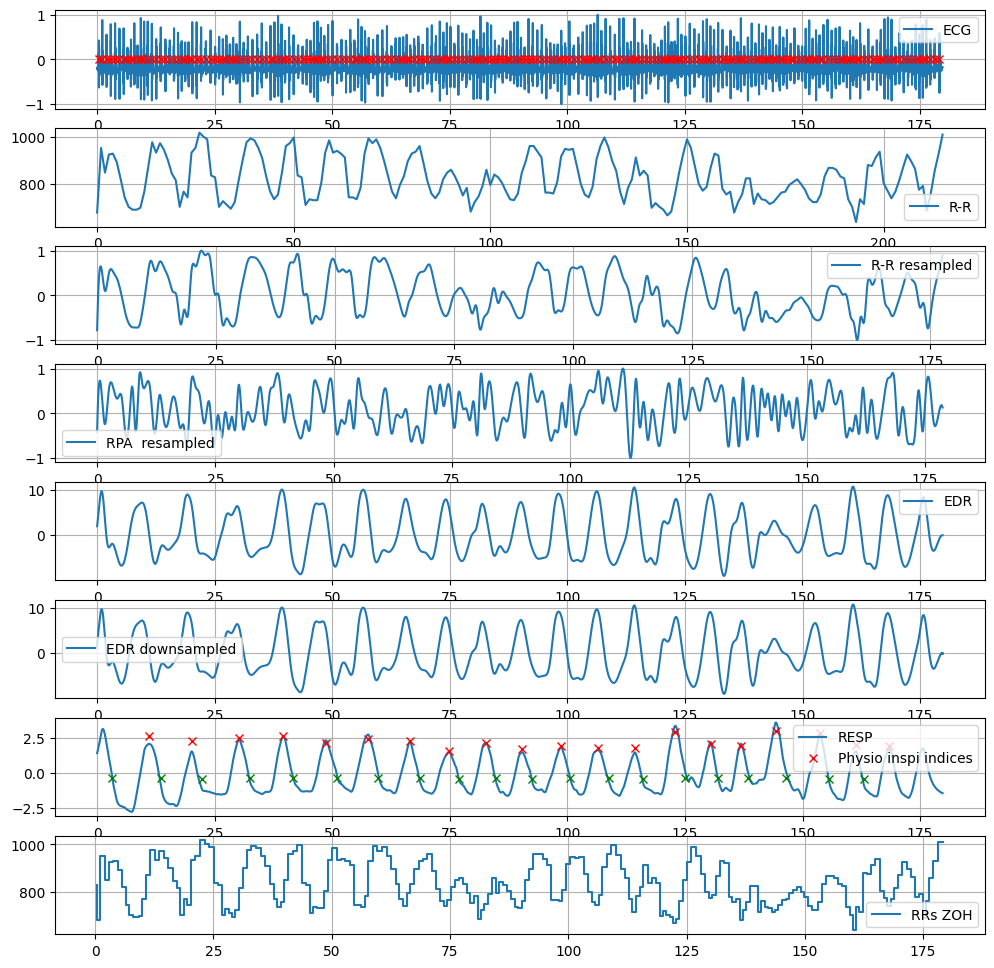

In [51]:
fig, axs = plt.subplots(nrows=8)

ax = axs[0]
ax.plot(t_ecg, ecg_slice)
ax.plot(R_wave_indices * 1/aidmed_ecg_sampling_rate + t_ecg[0], ecg[R_wave_indices,0], 'rx')
ax.grid()
ax.legend(["ECG"])

ax = axs[1]
ax.plot(rr_intervals)
ax.grid()
ax.legend(["R-R"])

ax = axs[2]
ax.plot(t_resampled, rr_interpolated)
ax.grid()
ax.legend(["R-R resampled"])

ax = axs[3]
ax.plot(rpa_t_resampled, rpa_interpolated)
ax.grid()
ax.legend(["RPA  resampled"])

ax = axs[4]
ax.plot(t_ecg, edr)
ax.grid()
ax.legend(["EDR"])

ax = axs[5]
ax.plot(t_resp, edr_resampled)
ax.grid()
ax.legend(["EDR downsampled"])

ax = axs[6]
ax.plot(t_resp, resp_slice)
ax.plot(resp_peaks * 1/aidmed_resp_sampling_rate + t_resp[0], clean_resp[resp_peaks], 'rx')
ax.plot(inspi_indices * 1/aidmed_resp_sampling_rate + t_resp[0], clean_resp[inspi_indices], 'gx')
ax.grid()
ax.legend(["RESP", "Neurokit resp indices"])
ax.legend(["RESP", "Physio inspi indices"])

ax = axs[7]
ax.step(R_wave_time, [np.mean(rr_intervals)] + rr_intervals.tolist())
ax.grid()
ax.legend(["RRs ZOH"])

fig.set_size_inches(12,12)


In [72]:
def normalized_cross_correlation(x, y):
    assert len(x) == len(y), "Signals must have the same length."
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    x_prime = x - mean_x
    y_prime = y - mean_y
    
    covariance = np.sum(x_prime * y_prime)
    
    std_x = np.sqrt(np.sum(x_prime ** 2))
    std_y = np.sqrt(np.sum(y_prime ** 2))
    
    if std_x != 0 and std_y != 0:
        r_xy = covariance / (std_x * std_y)
    else:
        r_xy = 0
    
    return r_xy

In [73]:
edr_tensor_1 = norm_min_max(edr_resampled[ : 75 * aidmed_resp_sampling_rate], -1, 1)
edr_tensor_2 = norm_min_max(edr_resampled[75* aidmed_resp_sampling_rate : 150 * aidmed_resp_sampling_rate], -1 ,1)

resp_target_slice_1 = norm_min_max(resp_slice[ : 75 * aidmed_resp_sampling_rate], -1, 1)
resp_target_slice_2 = norm_min_max(resp_slice[75* aidmed_resp_sampling_rate : 150 * aidmed_resp_sampling_rate], -1, 1)

cross_coef_1 = normalized_cross_correlation(edr_tensor_1, resp_target_slice_1)
cross_coef_2 = normalized_cross_correlation(edr_tensor_2, resp_target_slice_2)

C:\Users\patry\AppData\Local\Temp\ipykernel_12616\2701115669.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


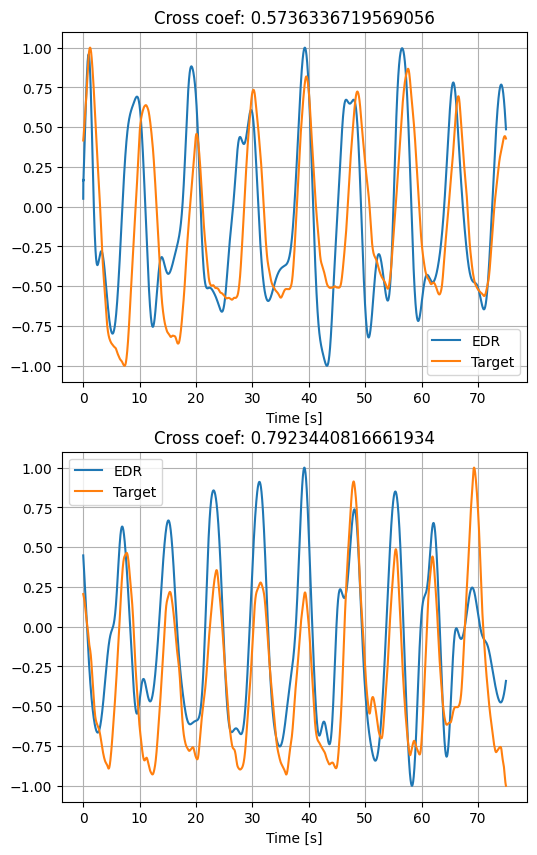

In [75]:
fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.plot([x/aidmed_resp_sampling_rate  for x in range(len(edr_tensor_1))], edr_tensor_1)
ax.plot([x/aidmed_resp_sampling_rate  for x in range(len(resp_target_slice_1))], resp_target_slice_1)
ax.grid()
ax.legend(["EDR", "Target"])
ax.set_xlabel("Time [s]")
ax.set_title(f"Cross coef: {cross_coef_1}")

ax = axs[1]
ax.plot([x/aidmed_resp_sampling_rate  for x in range(len(edr_tensor_2))], edr_tensor_2)
ax.plot([x/aidmed_resp_sampling_rate  for x in range(len(resp_target_slice_2))], resp_target_slice_2)
ax.grid()
ax.legend(["EDR", "Target"])
ax.set_xlabel("Time [s]")
ax.set_title(f"Cross coef: {cross_coef_2}")

fig.set_size_inches(6,10)
fig.show()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firls, filtfilt
from scipy.signal.windows import hamming
from scipy.interpolate import CubicSpline

# Define the FIR filter design function with window
def fir_least_squares_bandpass_with_window(lowcut, highcut, fs, numtaps):
    # Normalize the cutoff frequencies
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Define the desired frequency response
    bands = [0, low, low, high, high, 1]
    desired = [0, 0, 1, 1, 0, 0]
    
    # Create the FIR filter using firls (least-squares method)
    taps = firls(numtaps, bands, desired)
    
    # Apply Hamming window to the FIR filter coefficients
    window = hamming(numtaps)
    taps *= window
    
    return taps

# Apply the FIR filter to the data (standard filtering)
def apply_zero_phase_filter(data, taps):
    return filtfilt(taps, 1.0, data)

# Example R-R interval signal (resampled at 4 Hz)
fs = 10  # Sampling frequency (Hz)
numtaps = 51  # Number of filter taps (odd number for FIR filter)
lowcut = 0.1  # Low cutoff frequency (Hz)
highcut = 0.4  # High cutoff frequency (Hz)

# Design the least-squares FIR bandpass filter with window
taps = fir_least_squares_bandpass_with_window(lowcut, highcut, fs, numtaps)

# Apply the zero-phase FIR filter
filtered_rr_intervals = apply_zero_phase_filter(rr_interpolated, taps)
filtered_rpa = apply_zero_phase_filter(rpa_interpolated, taps)
filtered_edr = apply_zero_phase_filter(edr, taps)

filtered_rsp = apply_zero_phase_filter(resp, taps)

# Plot original and filtered signal
plt.figure(figsize=(12, 6))

plt.subplot(3, 2, 1)
plt.plot(t_resampled, rr_interpolated, 'b-', label='Original R-R Intervals')
plt.title('Original R-R Intervals')
plt.xlabel('Time (s)')
plt.ylabel('R-R Interval (ms)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(rpa_t_resampled, rpa_interpolated, 'g-', label='Original RPA')
plt.title('Original RPA')
plt.xlabel('Time (s)')
plt.ylabel('R-R Interval (ms)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t_ecg, edr, 'r-', label='Original EDR')
plt.title('Original EDR')
plt.xlabel('Time (s)')
plt.ylabel('EDR')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t_resampled, filtered_rr_intervals, 'r-', label='Filtered R-R Intervals (0.1-0.4 Hz)')
plt.title('Filtered R-R')
plt.xlabel('Time (s)')
plt.ylabel('RPA')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(rpa_t_resampled, filtered_rpa, 'r-', label='Filtered RPA (0.1-0.4 Hz)')
plt.title('Filtered RPA')
plt.xlabel('Time (s)')
plt.ylabel('RPA')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t_ecg, filtered_edr, 'r-', label='Filtered EDR (0.1-0.4 Hz)')
plt.title('Filtered EDR')
plt.xlabel('Time (s)')
plt.ylabel('RPA')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


ValueError: The length of the input vector x must be greater than padlen, which is 153.

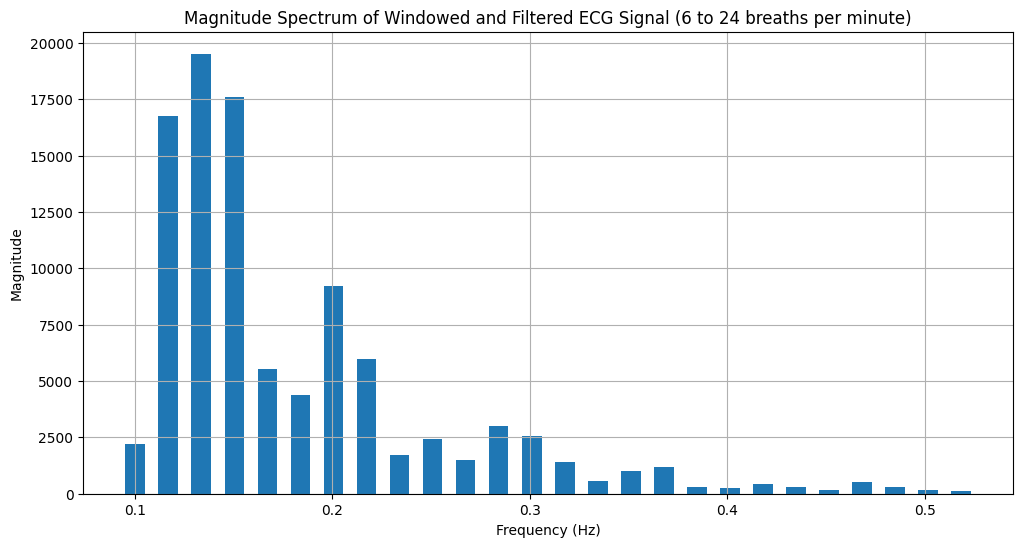

Respiratory rate frequency:  0.13374348000534975 Breaths per minute:  8.024608800320985


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# # Example parameters
sampling_rate =  250  # Hz
signal_length = len(edr) # Number of samples (60 seconds)

# # Step 1: Design a FIR band-pass filter
# # Pass band range: 0.1 to 1 Hz
# low_cutoff = 0.1  # Hz
# high_cutoff = 1.0  # Hz
# numtaps = 101  # Number of filter taps

# # Design the filter
# fir_coeff = firwin(numtaps, [low_cutoff, high_cutoff], fs=sampling_rate, pass_zero=False)

# # Step 2: Apply the FIR band-pass filter
# ecg_filtered = lfilter(fir_coeff, 1.0, ecg)

# # Step 3: Create a Hamming window
# hamming_window = np.hamming(signal_length)

# # Step 4: Apply the Hamming window to the filtered ECG signal
# ecg_windowed = ecg_filtered * hamming_window

# Step 5: Compute the FFT of the windowed signal
ecg_fft_windowed = np.fft.fft(edr)

# Step 6: Compute the magnitude spectrum
ecg_magnitude_windowed = np.abs(ecg_fft_windowed)

# Step 7: Define the frequency axis
frequencies = np.fft.fftfreq(signal_length, d=1/sampling_rate)

# Step 8: Convert breaths per minute to Hz
breaths_per_minute_min = 6
breaths_per_minute_max = 32

frequency_min = breaths_per_minute_min / 60  # Convert BPM to Hz
frequency_max = breaths_per_minute_max / 60  # Convert BPM to Hz

# Find the indices corresponding to the desired frequency range
positive_freq_indices = np.where(frequencies >= 0)
frequencies_positive = frequencies[positive_freq_indices]
magnitude_positive = ecg_magnitude_windowed[positive_freq_indices]

# Find the range of indices corresponding to the desired frequency range
freq_indices = (frequencies_positive >= frequency_min) & (frequencies_positive <= frequency_max)
frequencies_range = frequencies_positive[freq_indices]
magnitude_range = magnitude_positive[freq_indices]

max_idx = np.argmax(magnitude_range)
rr_freq = frequencies_range[max_idx]

# Plot the magnitude spectrum for the specified frequency range
plt.figure(figsize=(12, 6))
plt.bar(frequencies_range, magnitude_range, width=0.01)
#plt.plot(rr_freq, magnitude_range[max_idx], 'rx')
plt.title('Magnitude Spectrum of Windowed and Filtered ECG Signal (6 to 24 breaths per minute)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

print("Respiratory rate frequency: ", rr_freq, "Breaths per minute: ", rr_freq * 60)
